In [1]:
import sys
sys.path.append('../../libmitigation')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time

In [3]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit
import qiskit.quantum_info as qi
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
from qiskit.result import Result
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *
from qiskit.compiler import transpile

In [5]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

/Users/yangbo/Documents/oss/qiskit-aqua/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


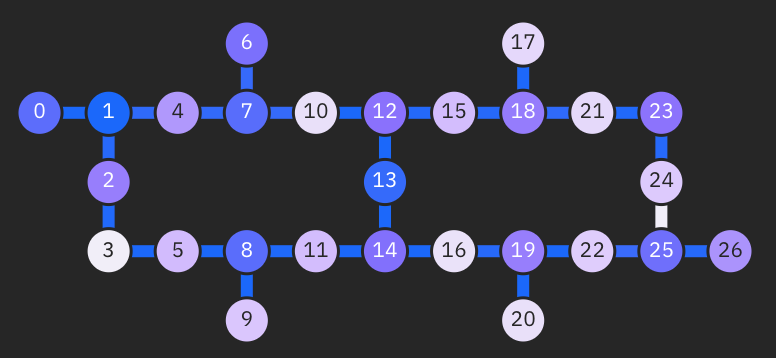

In [6]:
# qubit layout
vertex_list =  [13, # 0
                14, # 1
                12, 16, # 2, 3
                11, 10, 19, # 4, 5, 6
                15,  8,  7, 22, # 7, 8, 9, 10
                20, 18,  5,  4, 25, # 11, 12, 13, 14, 15
                 9,  6,  21, 3,  1, 24, # 16, 17, 18, 19, 20, 21
                17, 26, 23,  2,  0] # 22, 23, 24, 25, 26
def is_permutation(seq):
    return len(seq) == len(set(seq))
assert is_permutation(vertex_list)
max_size = len(vertex_list) # largest graph size
shots_per_circuit = 1 << 13 # shots per one execution
system_size = len(vertex_list)

In [7]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 27
system_size: 27
shots_per_circuit: 8192


In [8]:
# indicate how to connect qubits
order = [[0,1], # 2
         [0,2],  [1,3], # 3
         [1,4],  [2,5],  [3,6], # 4
         [2,7],  [4,8],  [5,9],  [6,10], # 5
         [6,11], [7,12], [8,13], [9,14], [10,15], # 6
         [8,16], [9,17], [12,18],[13,19],[14,20],[15,21], # 7
         [12,22],[15,23],[18,24],[19,25],[20,26]] # 8

In [9]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7]
27


In [10]:
def ghz_state(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    if size <= 1:
        qc.measure_all()
        return qc
    qc.h(0)
    depth = 0
    for i, j in order:
        if depth != qubit_depths[j]:
            qc.barrier()
            depth += 1
        qc.cx(i, j)
    qc.barrier()
    qc.measure_all()
    return qc

In [11]:
qcs = [ghz_state(size, order[:size-1], qubit_depths[:size]) for size in range(1, max_size+1)]

In [12]:
for qc in qcs:
    print(qc.num_qubits)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


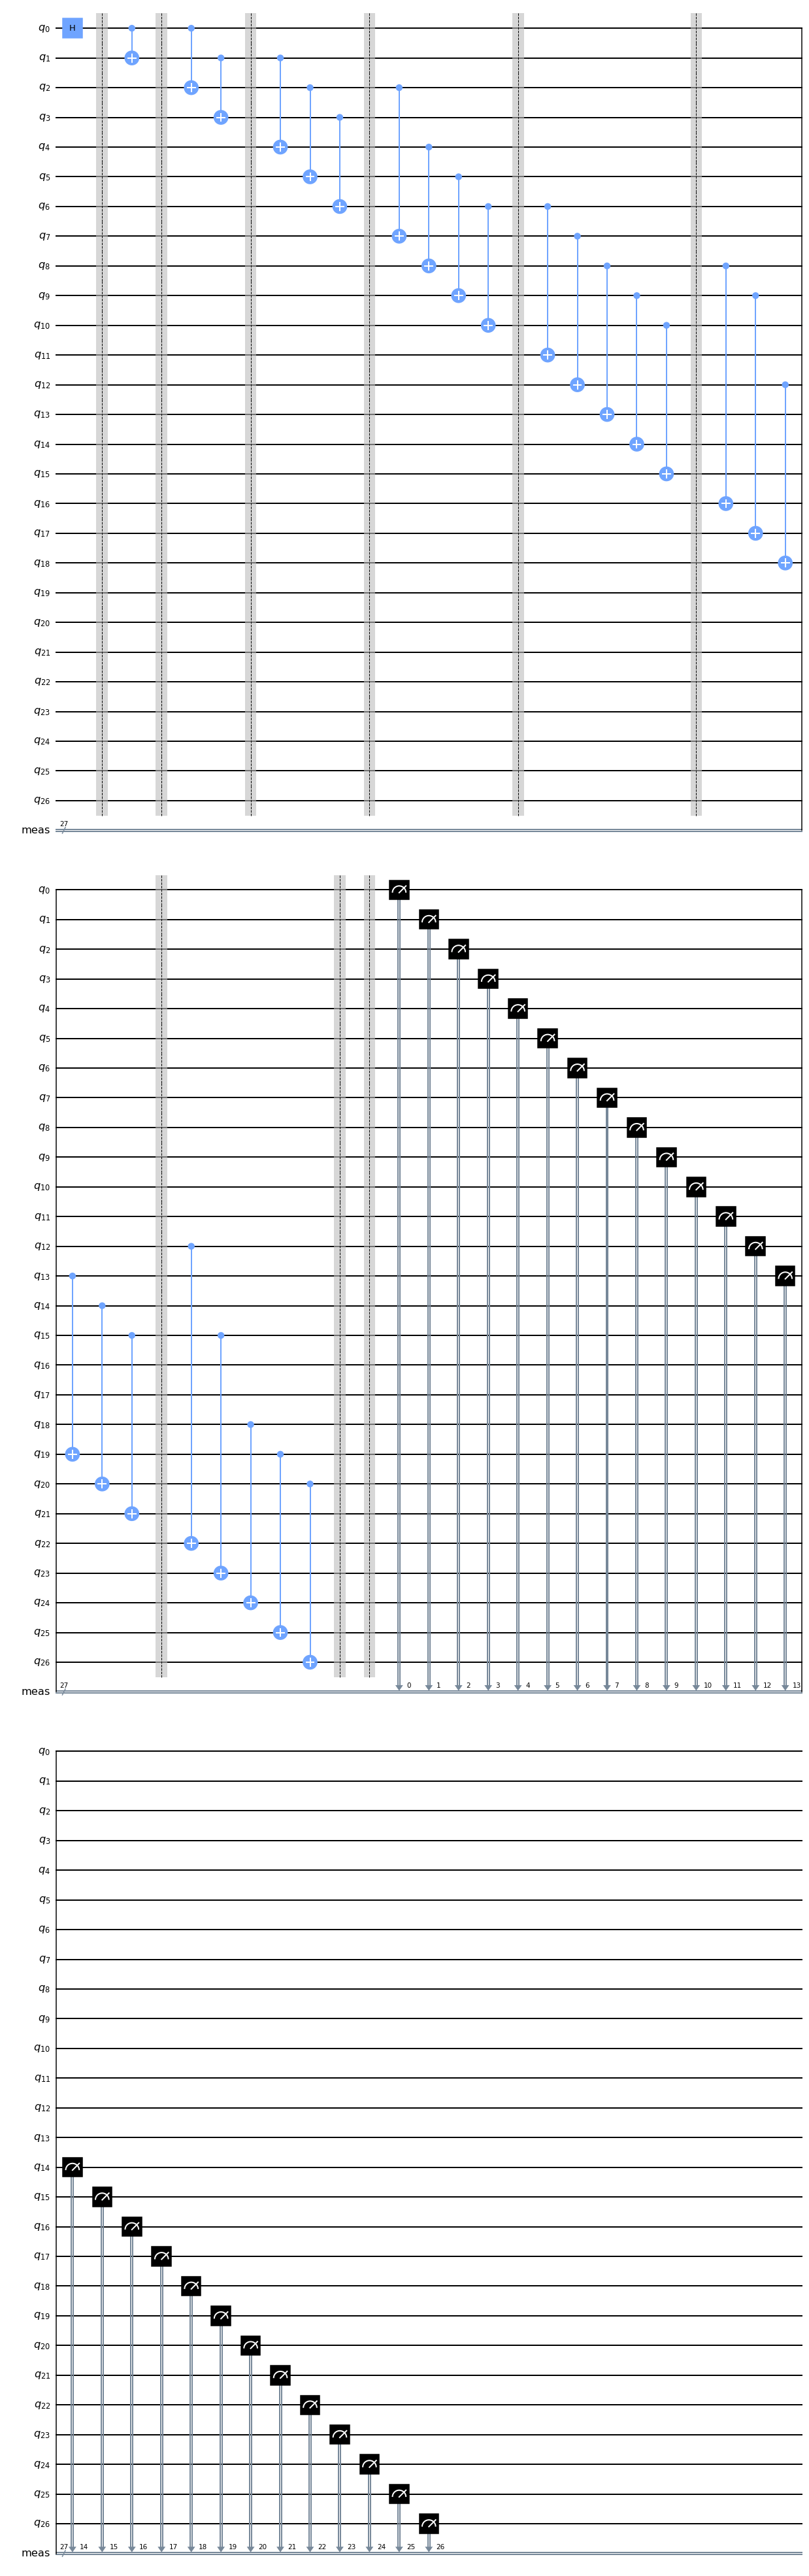

In [15]:
qcs[-1].draw("mpl")

In [16]:
def make_qcs_list(qcs):
    qcs_list = []
    mit_patterns = []
    for i in range(len(qcs)):
        qr = QuantumRegister(qcs[i].num_qubits)
        mit_pattern = [[i] for i in range(qcs[i].num_qubits)]
        meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
        qcs_list.append(qcs[i])
        qcs_list += meas_calibs
        mit_patterns.append(mit_pattern)
    return qcs_list, mit_patterns

In [17]:
qcs_list, mit_patterns = make_qcs_list(qcs)
print(len(qcs_list), len(mit_patterns))

81 27


In [16]:
for qc in qcs_list:
    print(qc.num_qubits)

1
1
1
2
2
2
3
3
3
4
4
4
5
5
5
6
6
6
7
7
7
8
8
8
9
9
9
10
10
10
11
11
11
12
12
12
13
13
13
14
14
14
15
15
15
16
16
16
17
17
17
18
18
18
19
19
19
20
20
20
21
21
21
22
22
22
23
23
23
24
24
24
25
25
25
26
26
26
27
27
27
28
28
28
29
29
29
30
30
30
31
31
31
32
32
32
33
33
33
34
34
34
35
35
35
36
36
36
37
37
37
38
38
38
39
39
39
40
40
40
41
41
41
42
42
42
43
43
43
44
44
44
45
45
45
46
46
46
47
47
47
48
48
48
49
49
49
50
50
50
51
51
51
52
52
52
53
53
53
54
54
54
55
55
55
56
56
56
57
57
57
58
58
58
59
59
59
60
60
60
61
61
61
62
62
62
63
63
63
64
64
64
65
65
65


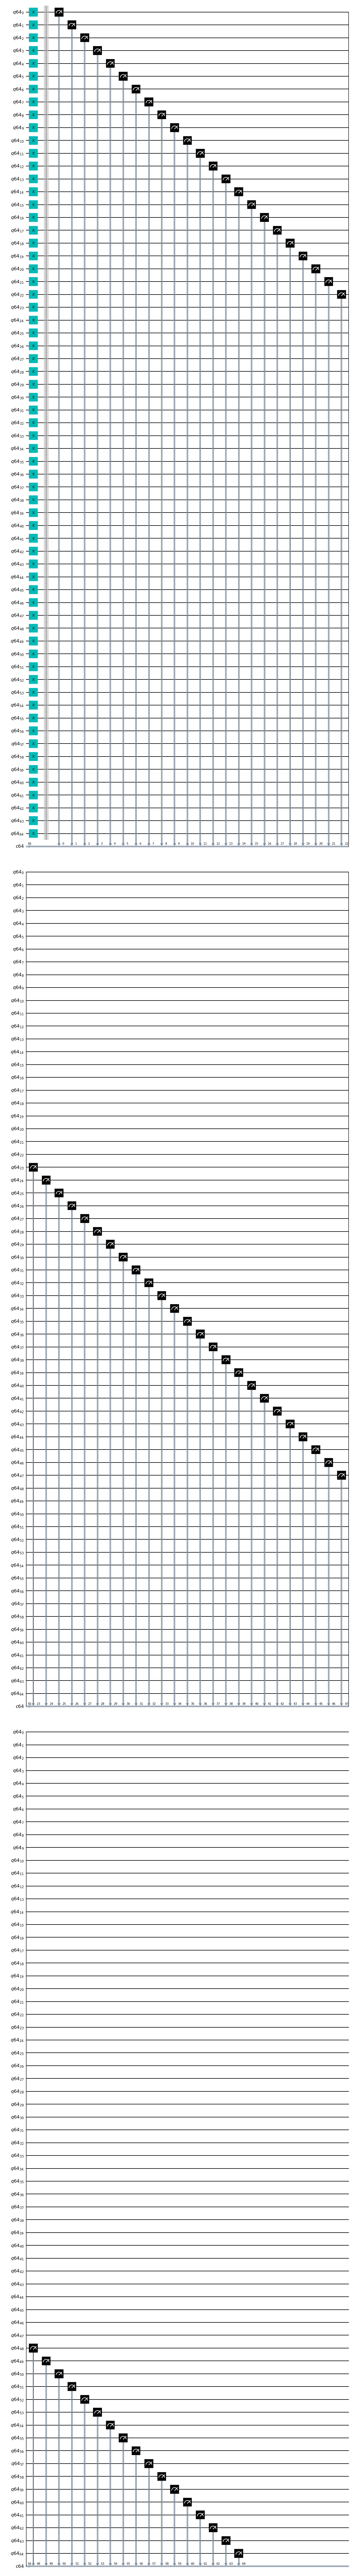

In [17]:
qcs_list[194].draw("mpl")

In [18]:
initial_layouts = []
for i in range(len(qcs_list)):
    initial_layouts.append( vertex_list[:qcs_list[i].num_qubits] )

In [19]:
# qc = transpile(qcs[-1], coupling_map=order, initial_layout=initial_layouts[-1])
# qc.draw("mpl")

In [19]:
device = provider.backends.ibmq_montreal
backend = provider.get_backend('ibmq_montreal')

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  """Entry point for launching an IPython kernel.


In [21]:
initial_layouts

[[33],
 [33],
 [33],
 [33, 32],
 [33, 32],
 [33, 32],
 [33, 32, 25],
 [33, 32, 25],
 [33, 32, 25],
 [33, 32, 25, 31],
 [33, 32, 25, 31],
 [33, 32, 25, 31],
 [33, 32, 25, 31, 34],
 [33, 32, 25, 31, 34],
 [33, 32, 25, 31, 34],
 [33, 32, 25, 31, 34, 19],
 [33, 32, 25, 31, 34, 19],
 [33, 32, 25, 31, 34, 19],
 [33, 32, 25, 31, 34, 19, 39],
 [33, 32, 25, 31, 34, 19, 39],
 [33, 32, 25, 31, 34, 19, 39],
 [33, 32, 25, 31, 34, 19, 39, 30],
 [33, 32, 25, 31, 34, 19, 39, 30],
 [33, 32, 25, 31, 34, 19, 39, 30],
 [33, 32, 25, 31, 34, 19, 39, 30, 35],
 [33, 32, 25, 31, 34, 19, 39, 30, 35],
 [33, 32, 25, 31, 34, 19, 39, 30, 35],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18, 45],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18, 45],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18, 45],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18, 45, 20],
 [33, 32, 25, 31, 34, 19, 39, 30, 35, 18, 45, 20],
 [33, 3

In [20]:
job = execute(qcs_list,
               backend=backend, 
               shots=shots_per_circuit,
               optimization_level=1,
               initial_layout=initial_layouts)
print("job id:", job.job_id())

job id: 612277035221c483baf21191


In [1]:
result = job.result()
print(len(result))

NameError: name 'job' is not defined